In [1]:
import pandas as pd
import numpy as np
import json
import yaml
from scipy import stats
import seaborn as sn
import pickle

from statsmodels.stats.multitest import multipletests
from matplotlib import pyplot as plt
from scipy.stats import rankdata

In [2]:
def parser_method_dict(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Nb_Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]):
        row = yaml.safe_load(df.iloc[i].iloc[0])
        dataf.loc[i] = [np.trapz(row[j]) for j in row]
    #print(dataf)
    return dataf

In [3]:
def parser_method_dict_with_layers(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Nb_Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
        Note that df.iloc[0] has a dic e.g., {"layer1": [list of corr of bacth], "layer2": [list of corr of batch]}
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]): # loop over the number of batches
        row = yaml.safe_load(df.iloc[i].iloc[0]) # Get the batch result
        
        # p is the index of image, j is the layer_name, np.trapz computes the AUC
        dataf.loc[i] = [np.trapz([row[j][p] for j in row]) for p in range(batch)]
    return dataf

In [4]:
metrics =  [
    'Monotonicity Nguyen',
    'Local Lipschitz Estimate',
    'Faithfulness Estimate',
    'Faithfulness Correlation',
    'Avg-Sensitivity',
    'Random Logit',
    'Max-Sensitivity',
    'Sparseness', 
    'EffectiveComplexity',
    'Monotonicity Arya',
    'Complexity',
    'Pixel-Flipping',
    'Selectivity',
    'Model Parameter Randomisation'
]
                # ['SensitivityN': problem with implementation,
                #'Region Perturbation' seems to be same as region perturbation, 
                #'Continuity Test': Difficult to aggregate result, the paper just plot it
                #'Completeness' always returns False]
                # Nonsentitivity is removed

metrics_with_different_baselines = {
    'Faithfulness Estimate',
    'Faithfulness Correlation',
    'Monotonicity Arya',
    'Monotonicity Nguyen',
    'Pixel-Flipping',
    'Selectivity',
}
                
baselines = [
    'baseline_black',
    'baseline_mean',
    'baseline_random',
    'baseline_uniform',
    'baseline_white'
]

transform = {
    'Monotonicity Nguyen': lambda x: x,
    'Local Lipschitz Estimate': lambda x: -x, 
    'Faithfulness Estimate': abs,
    'Faithfulness Correlation': abs, 
    'Avg-Sensitivity': lambda x: -x,
    'Random Logit': lambda x: x,
    'Sparseness': lambda x: x,
    'EffectiveComplexity': lambda x: -x,
    'Nonsensitivity': lambda x: -x,
    'Pixel-Flipping': lambda x: x.apply(lambda row: - np.trapz(row), axis=1),
    'Max-Sensitivity': lambda x: -x,
    'Complexity': lambda x: -x, 
    "Selectivity": lambda x: -parser_method_dict(x),
    'Model Parameter Randomisation': lambda x: parser_method_dict_with_layers(x),
    'Monotonicity Arya': lambda x: x,
}

methods = ['integratedgrad', 'smoothgrad', 'guidedbackprop', 'rise', 'gradcam',
           'scorecam', 'layercam', 'random', 'sobel', "gaussian", "polycam"]

model = "resnet50"
dataset = "imagenet"

dico_ranks = {}
alpha = 0.05 #Seuil de significativité

In [ ]:
for metr in metrics:
    if metr in metrics_with_different_baselines:
        for baseline in baselines:
            data = pd.DataFrame()
            metr_with_baseline = f'{metr} with {baseline}'
            print(f"-- Metric: {metr_with_baseline}")
            for meth in methods:
                csv_name = f"csv/{meth}_{model}_{dataset}_{metr}_{baseline}.csv"
                df = pd.read_csv(csv_name, header = None)
                data[meth] = transform[metr](df).values.flatten()    
            ranks = np.array([rankdata(-p) for p in data.values])
            average_ranks = np.mean(ranks, axis=0)
            dico_ranks[metr_with_baseline] = average_ranks
    elif metr == 'Model Parameter Randomisation':
        for baseline in ['bottom_up','top_down']:
            data = pd.DataFrame()
            metr_with_baseline = f'{metr} with {baseline}'
            print(f"-- Metric: {metr_with_baseline}")
            for meth in methods:
                csv_name = f"csv/{meth}_{model}_{dataset}_{metr}_{baseline}.csv"
                df = pd.read_csv(csv_name, header = None)
                data[meth] = transform[metr](df).values.flatten()    
            ranks = np.array([rankdata(-p) for p in data.values])
            average_ranks = np.mean(ranks, axis=0)
            dico_ranks[metr_with_baseline] = average_ranks
    else:
        data = pd.DataFrame()
        print(f"-- Metric: {metr}")
        for meth in methods:
            csv_name = f"csv/{meth}_{model}_{dataset}_{metr}.csv"
            df = pd.read_csv(csv_name, header = None)
            data[meth] = transform[metr](df).values.flatten()    
        ranks = np.array([rankdata(-p) for p in data.values])
        average_ranks = np.mean(ranks, axis=0)
        dico_ranks[metr] = average_ranks

with open('rankings_by_rank_aggreg.pickle', 'wb') as file:
    pickle.dump(dico_ranks, file)

In [5]:
with open('rankings_by_rank_aggreg.pickle', 'rb') as file:
    dico_ranks = pickle.load(file)

In [6]:
df_ranks = pd.DataFrame(dico_ranks, index= methods)
metrics_with_baselines = sorted(dico_ranks.keys())

In [7]:
df_ranks

,Monotonicity Nguyen with baseline_black,Monotonicity Nguyen with baseline_mean,Monotonicity Nguyen with baseline_random,Monotonicity Nguyen with baseline_uniform,Monotonicity Nguyen with baseline_white,Local Lipschitz Estimate,Faithfulness Estimate with baseline_black,Faithfulness Estimate with baseline_mean,Faithfulness Estimate with baseline_random,Faithfulness Estimate with baseline_uniform,...,Pixel-Flipping with baseline_random,Pixel-Flipping with baseline_uniform,Pixel-Flipping with baseline_white,Selectivity with baseline_black,Selectivity with baseline_mean,Selectivity with baseline_random,Selectivity with baseline_uniform,Selectivity with baseline_white,Model Parameter Randomisation with bottom_up,Model Parameter Randomisation with top_down
integratedgrad,6.5780,4.7705,4.4925,5.5655,6.2190,0.130857,6.7640,2.8740,3.2395,5.6935,...,1.9230,4.0050,3.7955,4.0605,4.7495,4.7590,4.5450,4.2115,9.1335,9.1080
smoothgrad,4.9140,4.7215,4.8360,4.6105,4.7800,0.262536,5.1420,5.1875,5.3035,5.0350,...,6.1890,5.9480,5.4015,5.2280,5.3710,5.3605,5.2385,5.2505,2.0080,1.9765
guidedbackprop,6.7385,6.7965,6.8300,7.1455,6.4915,0.107214,7.8930,7.9925,8.0920,8.7440,...,7.4240,7.1195,4.4145,5.0745,5.5785,5.4295,5.3330,5.1930,9.6280,9.5465
rise,6.1545,6.5910,6.7560,6.6190,6.4680,0.673964,5.0330,5.5120,5.5650,5.2175,...,5.8115,5.4320,6.2335,5.5590,5.6505,5.6440,5.6100,5.6380,5.8420,5.8740
gradcam,4.4895,4.8290,4.7335,4.2315,4.5585,0.446750,4.6880,5.4400,5.3435,4.8140,...,5.6995,5.3530,7.2080,7.5160,7.0430,7.0310,7.1665,7.4085,5.3700,5.3350
scorecam,4.6750,4.7810,4.8320,4.3900,4.7285,0.498964,5.0495,5.6645,5.5230,5.0075,...,5.9370,5.7105,7.3425,7.4160,6.9500,7.0035,7.0740,7.2160,5.2670,5.2775
layercam,4.3000,4.3030,4.3065,3.8995,4.3300,0.664357,5.0070,5.8610,5.6575,4.9880,...,6.0265,5.6090,6.9560,7.3715,6.9190,6.9520,7.1005,7.3325,5.6420,5.6165
random,8.3550,8.2950,8.0525,8.4175,8.2775,0.585893,10.1975,10.1320,10.1405,9.7840,...,7.7415,8.1350,5.3810,3.8245,4.4780,4.4445,4.3330,3.9230,9.2735,9.2290
sobel,8.2520,9.2820,9.4435,9.4670,8.4135,0.223750,6.0950,6.3775,6.2415,6.3085,...,7.5465,6.9465,5.7435,5.6985,6.2045,6.1420,6.0395,5.8965,5.6945,5.6970
gaussian,6.1065,5.9320,6.1100,6.2660,6.3015,0.760286,4.9450,5.3960,5.4030,5.1765,...,5.8290,5.8215,6.9695,7.1590,6.2555,6.3460,6.6100,6.9080,1.5455,1.5495


In [55]:
def compute_kendall_w(dico_ranks, metrics):
    rankings = [rankdata(dico_ranks[metric]) for metric in metrics]
        
    data = []
    for i in range(len(rankings[0])):
        data.append([rankings[j][i] for j in range(len(rankings))])   
    
    # source of the implementation : https://github.com/ugolbck/kendall-w/blob/master/kendall_w/kendall_w.py
    m = len(data[0])
    n = len(data)
    sums = [sum(x) for x in data]
    Rbar = sum(sums) / n
    S = sum([(sums[x] - Rbar) ** 2 for x in range(n)])
    W = (12 * S) / (m ** 2 * (n ** 3 - n))

    return W

In [56]:
def compute_kendall_tau(dico_ranks, metrics):
    tau_values = []
    p_values = []

    for metric_a in metrics:
        current_tau_values = []
        current_p_values = []
        for metric_b in metrics:
            tau, p_value = stats.kendalltau(dico_ranks[metric_a], dico_ranks[metric_b])
            current_tau_values.append(tau)
            current_p_values.append(p_value)
        tau_values.append(current_tau_values)
        p_values.append(current_p_values)
        
    return tau_values, p_values

In [57]:
tau_values, p_values = compute_kendall_tau(dico_ranks, metrics_with_baselines)

In [58]:
def plot_corr_matrix(tau_values, p_values, labels, masked=False, show=True, save=False, path='', fig_size=(23.4,16.54)):
    sn.set(rc={'figure.figsize': fig_size})
    if masked:
        p_values_flattened = [p_value for sublist in p_values for p_value in sublist]
        reject, _, _, _ = multipletests(p_values_flattened, alpha=0.05, method='holm')
        sn.heatmap(tau_values,
                   annot=True,
                   vmin=-1,
                   vmax=1,
                   xticklabels=labels,
                   yticklabels=labels,
                   mask=np.invert(reject).reshape((len(labels),len(labels))),
                   cmap='viridis')
    else:
        sn.heatmap(tau_values,
           annot=True,
           vmin=-1,
           vmax=1,
           xticklabels=labels,
           yticklabels=labels,
           cmap='viridis')
    
    if save:
        plt.savefig(path, bbox_inches='tight')
    if show:
        plt.show()
    plt.close()

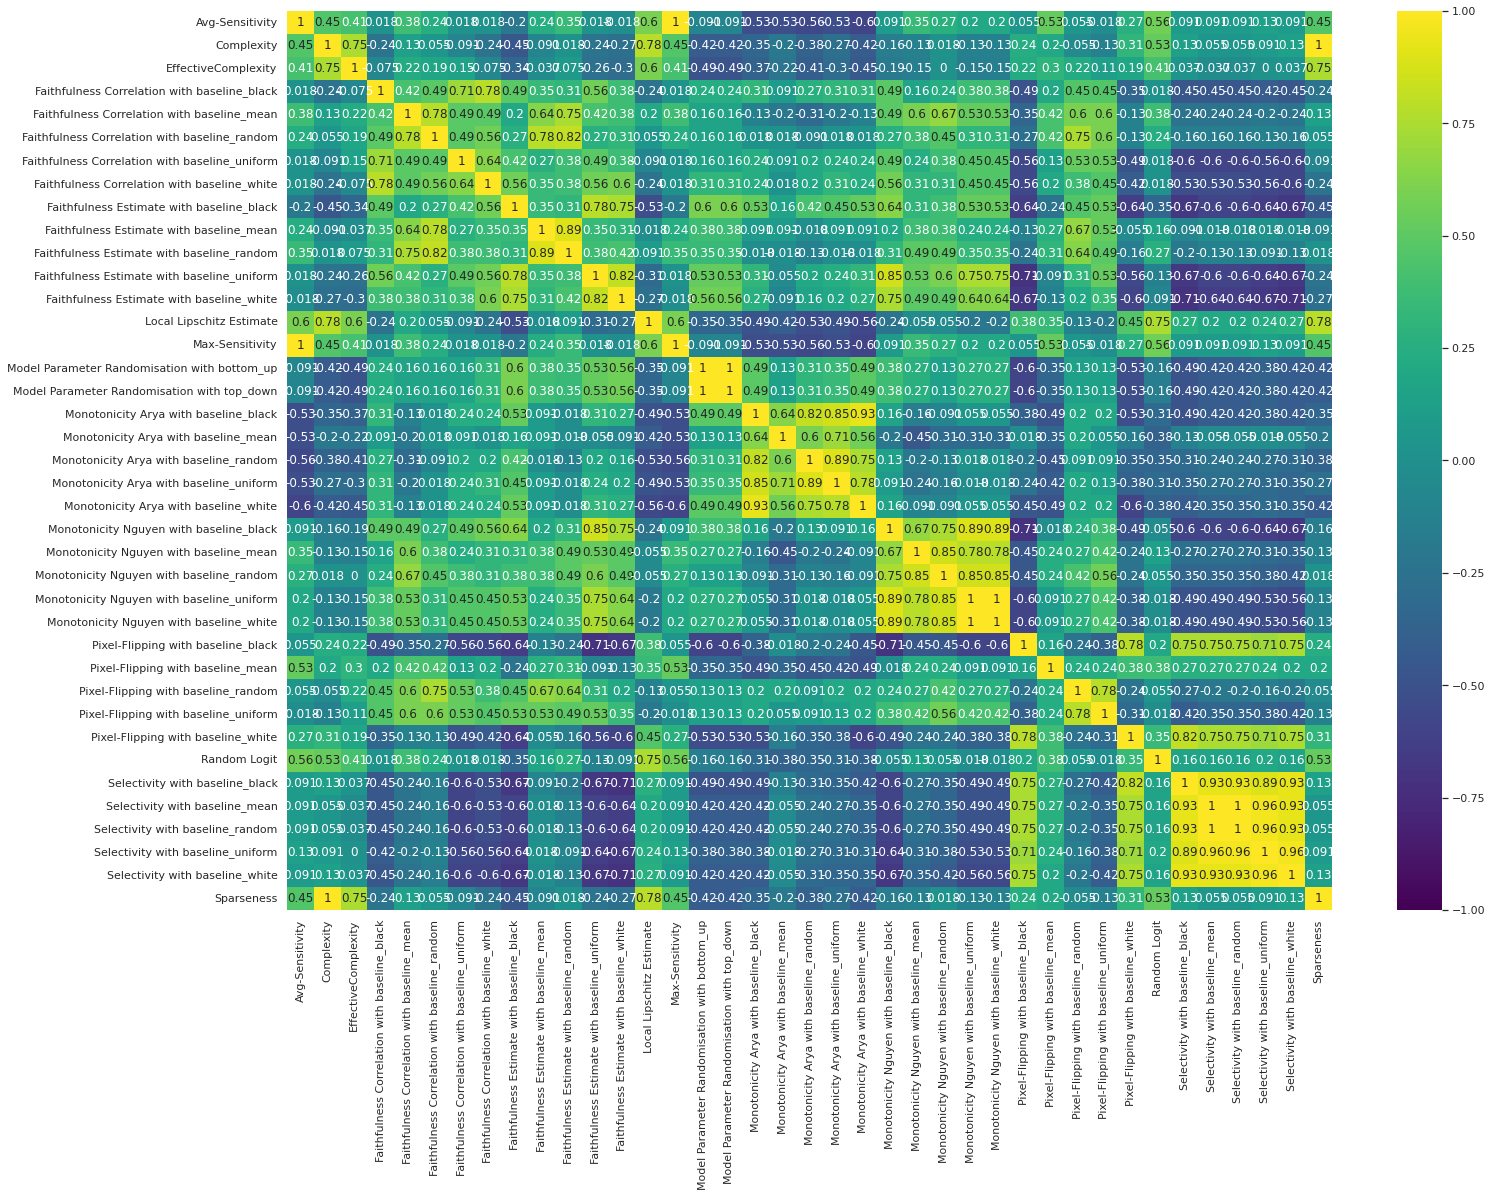

In [59]:
plot_corr_matrix(tau_values, p_values, metrics_with_baselines)

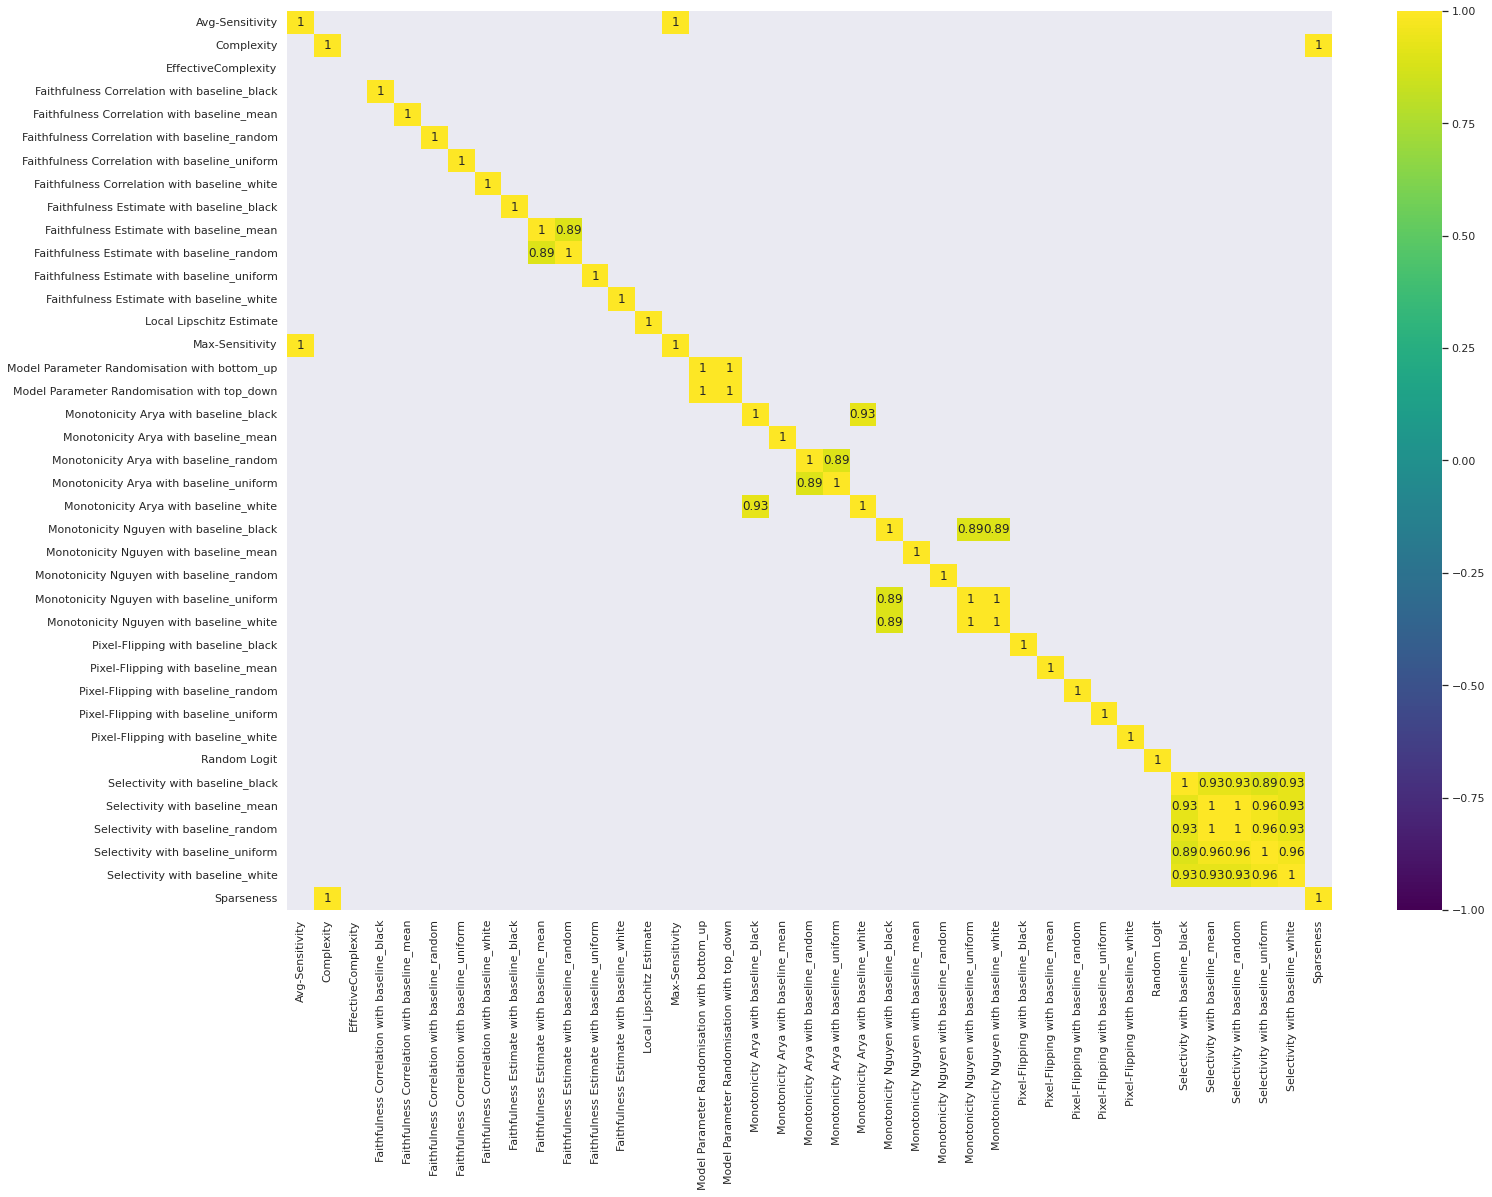

In [60]:
# Correlation Matrix with only significative values (Holm Correction)
plot_corr_matrix(tau_values, p_values, metrics_with_baselines, masked=True, save=True, path='./results/corr_matrix_rank_aggreg_holm_corr.png')

In [61]:
compute_kendall_w(dico_ranks, metrics_with_baselines)

0.10587532125993665

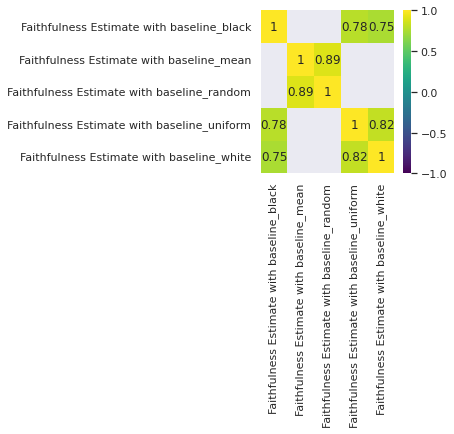

In [62]:
selected_metrics = [m for m in metrics_with_baselines if 'Faithfulness Estimate' in m]
selected_tau_values, selected_p_values = compute_kendall_tau(dico_ranks, selected_metrics)
plot_corr_matrix(selected_tau_values, selected_p_values, selected_metrics, masked=True, save=True,
                 path='./results/corr_matrix_rank_aggreg_holm_corr_faithfulness_estimate.png', fig_size=(3,3))

In [63]:
compute_kendall_w(dico_ranks, selected_metrics)

0.704

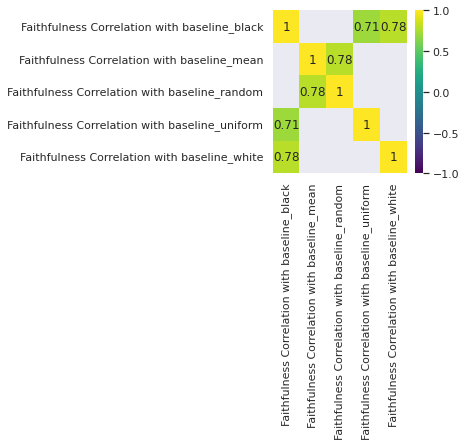

In [64]:
selected_metrics = [m for m in metrics_with_baselines if 'Faithfulness Correlation' in m]
selected_tau_values, selected_p_values = compute_kendall_tau(dico_ranks, selected_metrics)
plot_corr_matrix(selected_tau_values, selected_p_values, selected_metrics, masked=True, save=True,
                 path='./results/corr_matrix_rank_aggreg_holm_corr_faithfulness_correlation.png', fig_size=(3,3))

In [65]:
compute_kendall_w(dico_ranks, selected_metrics)

0.765090909090909

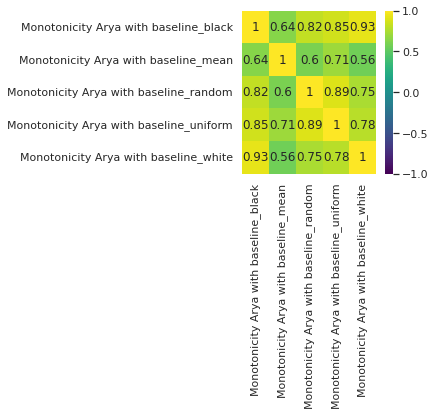

In [66]:
selected_metrics = [m for m in metrics_with_baselines if 'Monotonicity Arya' in m]
selected_tau_values, selected_p_values = compute_kendall_tau(dico_ranks, selected_metrics)
plot_corr_matrix(selected_tau_values, selected_p_values, selected_metrics, masked=True, save=True,
                 path='./results/corr_matrix_rank_aggreg_holm_corr_monotonicity_arya.png', fig_size=(3,3))

In [67]:
compute_kendall_w(dico_ranks, selected_metrics)

0.8923636363636364

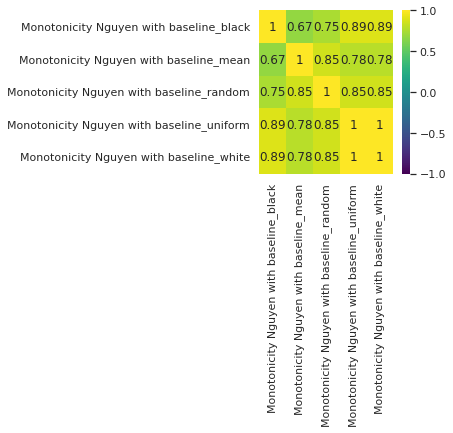

In [68]:
selected_metrics = [m for m in metrics_with_baselines if 'Monotonicity Nguyen' in m]
selected_tau_values, selected_p_values = compute_kendall_tau(dico_ranks, selected_metrics)
plot_corr_matrix(selected_tau_values, selected_p_values, selected_metrics, masked=True, save=True,
                 path='./results/corr_matrix_rank_aggreg_holm_corr_monotonicity_nguyen.png', fig_size=(3,3))

In [69]:
compute_kendall_w(dico_ranks, selected_metrics)

0.9250909090909091

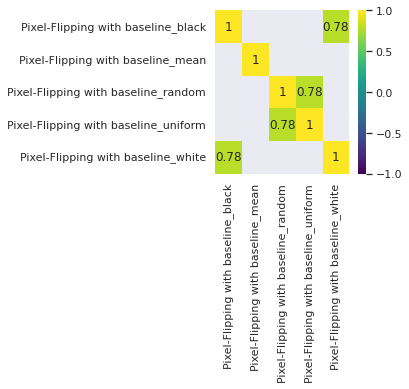

In [70]:
selected_metrics = [m for m in metrics_with_baselines if 'Pixel-Flipping' in m]
selected_tau_values, selected_p_values = compute_kendall_tau(dico_ranks, selected_metrics)
plot_corr_matrix(selected_tau_values, selected_p_values, selected_metrics, masked=True, save=True,
                 path='./results/corr_matrix_rank_aggreg_holm_corr_pixel_flipping.png', fig_size=(3,3))

In [71]:
compute_kendall_w(dico_ranks, selected_metrics)

0.3381818181818182

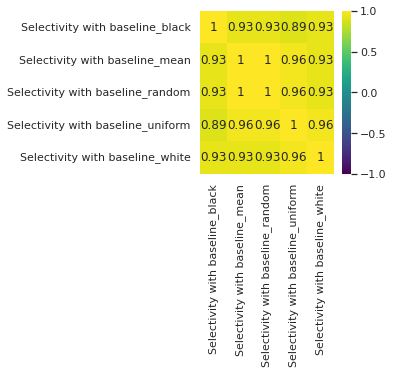

In [72]:
selected_metrics = [m for m in metrics_with_baselines if 'Selectivity' in m]
selected_tau_values, selected_p_values = compute_kendall_tau(dico_ranks, selected_metrics)
plot_corr_matrix(selected_tau_values, selected_p_values, selected_metrics, masked=True, save=True,
                 path='./results/corr_matrix_rank_aggreg_holm_corr_selectivity.png', fig_size=(3,3))

In [73]:
compute_kendall_w(dico_ranks, selected_metrics)

0.9883636363636363